In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import numpy
import keras
from keras import backend as K

import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from wlc.WLweakener import computeM, generateWeak, weak_to_index, binarizeWeakLabels
from experiments.visualizations import plot_history
from experiments.visualizations import plot_multilabel_scatter

cmap = plt.cm.get_cmap('tab20')

random_state = 0

Using TensorFlow backend.


# Create a dataset with true labels

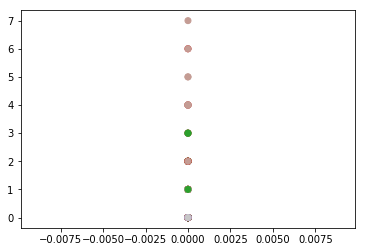

In [2]:
import sklearn.datasets as datasets

X, y = datasets.load_digits(return_X_y=True)
n_classes = 10
n_samples = X.shape[0]
n_features = X.shape[1]

Y = label_binarize(y, range(n_classes))
plt.scatter(X[:500,0], X[:500,1], c=y[:500], cmap=cmap)

# Generate weak labels

This will generate weak labels given the specified mixing process. It will also show 3 plots with the true labels, weak labels and the corresponding rows of the mixing matrix M.

[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0.4]
 [0.  0.  0.  ... 0.  0.4 0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]


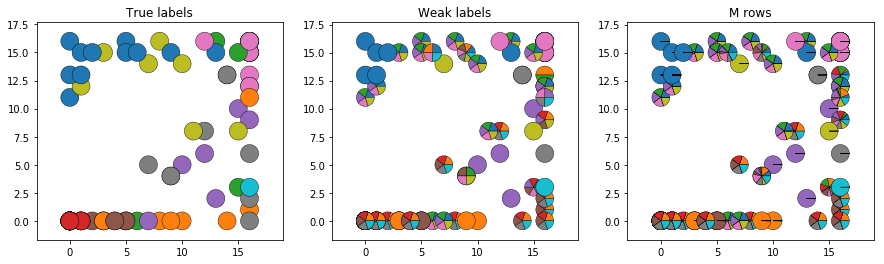

In [3]:
from wlc.WLweakener import weak_to_decimal

M_weak = numpy.zeros((2**n_classes, n_classes))
M_weak[weak_to_decimal(numpy.array([([0, 1]*n_classes)[:n_classes]]))] = ([0, 1]*n_classes)[:n_classes]
M_weak[weak_to_decimal(numpy.array([([1, 0]*n_classes)[:n_classes]]))] = ([1, 0]*n_classes)[:n_classes]

M_random_weak = computeM(n_classes, alpha=0.7, beta=0.2, method='random_weak', seed=0)
M_weak += M_random_weak

if M_weak.shape[0] == 2**M_weak.shape[1]:
    M_weak[0,:] = 0
    M_weak /= M_weak.sum(axis=0)

print(numpy.round(M_weak, decimals=3))

z = generateWeak(y, M_weak, seed=0)
Z = binarizeWeakLabels(z, c=n_classes)

M_weak_indices = weak_to_index(Z, method='random_weak')
V_weak = M_weak[M_weak_indices]

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1)
_ = plot_multilabel_scatter(X[:100], Y[:100], fig=fig,
                            ax=ax, title='True labels', cmap=cmap)
ax = fig.add_subplot(1, 3, 2)
_ = plot_multilabel_scatter(X[:100], Z[:100], fig=fig,
                            ax=ax, title='Weak labels', cmap=cmap)
ax = fig.add_subplot(1, 3, 3)
_ = plot_multilabel_scatter(X[:100], V_weak[:100], fig=fig,
                            ax=ax, title='M rows', cmap=cmap)

# Divide into training (weak and true), validation and test

In [4]:
divide_proportions = numpy.array([0.5, 0.1, 0.1, 0.2])
# Ensure that all proportions sum to 1
divide_proportions /= divide_proportions.sum()
divide_proportions = numpy.cumsum(divide_proportions)
indices = (divide_proportions*X.shape[0]).astype(int)[:-1]
print('Proportions for the 4 partitions')
print(divide_proportions)
print('Indices of a total of {} samples'.format(X.shape[0]))
print(indices)

# # Divide into training (weak and true), validation and test
X_weak_train, X_true_train, X_val, X_test = numpy.array_split(X, indices)
Y_weak_train, Y_true_train, Y_val, Y_test = numpy.array_split(Y, indices)
Z_weak_train, Z_true_train, Z_val, Z_test = numpy.array_split(Z, indices)
V_weak_train, V_true_train, V_val, V_test = numpy.array_split(V_weak, indices)
y_weak_train, y_true_train, y_val, y_test = numpy.array_split(y, indices)

# Remove a portion of the weak data
train_proportion = 1.0
last_train_index = int(numpy.ceil(train_proportion*X_weak_train.shape[0]))
X_weak_train = X_weak_train[:last_train_index]
Y_weak_train = Y_weak_train[:last_train_index]
Z_weak_train = Z_weak_train[:last_train_index]
V_weak_train = V_weak_train[:last_train_index]
y_weak_train = y_weak_train[:last_train_index]

# Save the final model for each method
final_models = {}

Proportions for the 4 partitions
[0.55555556 0.66666667 0.77777778 1.        ]
Indices of a total of 1797 samples
[ 998 1198 1397]


# Define a common model

In [5]:
from keras.callbacks import EarlyStopping, Callback
from keras import regularizers

max_epochs = 1000

# Callback to show performance per epoch in the same line
class EpochCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        print('\rEpoch {}, val_loss = {:.2e}, val_acc = {:.2f}'.format(epoch, logs['val_loss'], logs['val_acc']), end=' ')

# Callback for early stopping
epoch_callback = EpochCallback()
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=int(max_epochs/20), 
                               verbose=2, mode='auto', baseline=None,
                               restore_best_weights=True)

def make_model(loss, l2=0.0):
    # Careful that it is ussing global variables for the input and output shapes
    numpy.random.seed(0)
    model = keras.models.Sequential() 
    model.add(keras.layers.Dense(Y.shape[1], input_dim=X.shape[1],
                                 kernel_regularizer=regularizers.l2(l2),
                                 activation='softmax'))
    model.compile(optimizer='adam', loss=loss, metrics=['ce', 'mse', 'acc'])
    return model

# Keyword arguments for the fit function
fit_kwargs = dict(validation_data=(X_val, Y_val), epochs=max_epochs, verbose=0,
                  callbacks=[early_stopping, epoch_callback], shuffle=True)

# Fully supervised (upperbound)

Train with all true labels

Epoch 95, val_loss = 1.85e-01, val_acc = 0.93 Restoring model weights from the end of the best epoch
Epoch 96, val_loss = 1.79e-01, val_acc = 0.93 Epoch 00097: early stopping


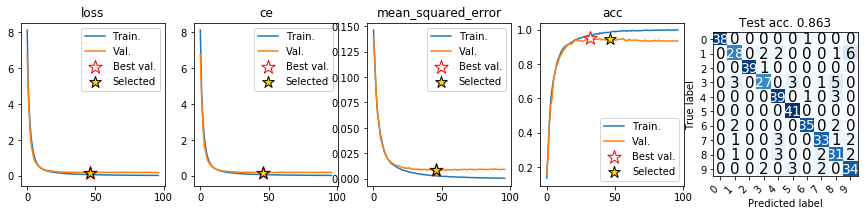

<Figure size 360x288 with 0 Axes>

Epoch 95, val_loss = 1.84e-01, val_acc = 0.93 Restoring model weights from the end of the best epoch
Epoch 96, val_loss = 1.78e-01, val_acc = 0.93 Epoch 00097: early stopping


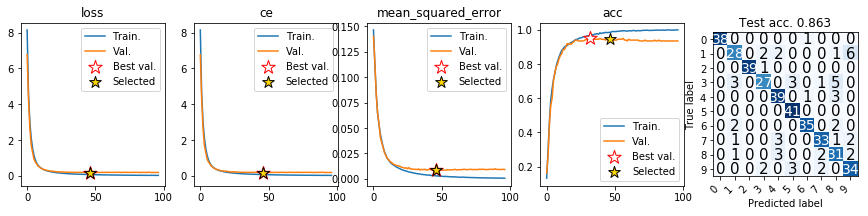

<Figure size 360x288 with 0 Axes>

Epoch 95, val_loss = 1.83e-01, val_acc = 0.93 Restoring model weights from the end of the best epoch
Epoch 96, val_loss = 1.77e-01, val_acc = 0.93 Epoch 00097: early stopping


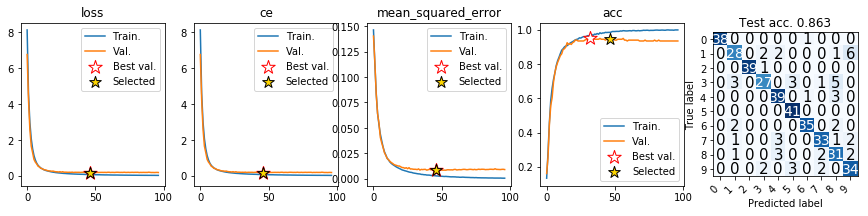

<Figure size 360x288 with 0 Axes>

Epoch 95, val_loss = 1.84e-01, val_acc = 0.93 Restoring model weights from the end of the best epoch
Epoch 96, val_loss = 1.79e-01, val_acc = 0.93 Epoch 00097: early stopping


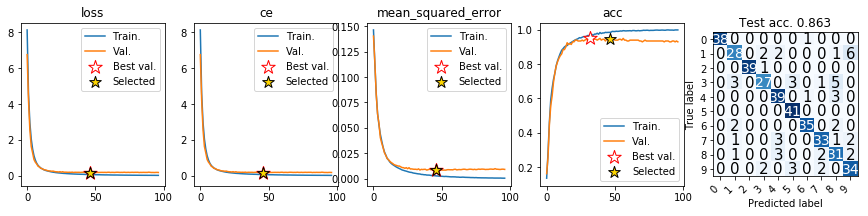

<Figure size 360x288 with 0 Axes>

Epoch 95, val_loss = 1.94e-01, val_acc = 0.93 Restoring model weights from the end of the best epoch
Epoch 96, val_loss = 1.89e-01, val_acc = 0.93 Epoch 00097: early stopping


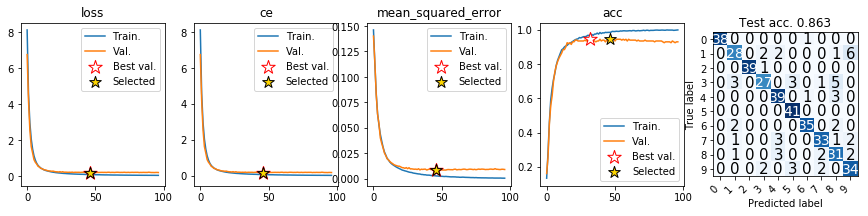

<Figure size 360x288 with 0 Axes>

Epoch 351, val_loss = 1.85e-01, val_acc = 0.94 Restoring model weights from the end of the best epoch
Epoch 352, val_loss = 1.77e-01, val_acc = 0.95 Epoch 00353: early stopping


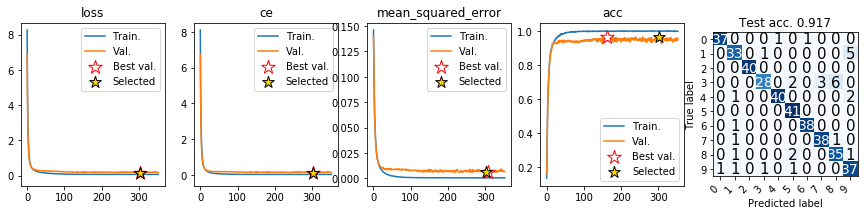

<Figure size 360x288 with 0 Axes>

Epoch 174, val_loss = 2.82e-01, val_acc = 0.96 Restoring model weights from the end of the best epoch
Epoch 175, val_loss = 2.97e-01, val_acc = 0.95 Epoch 00176: early stopping


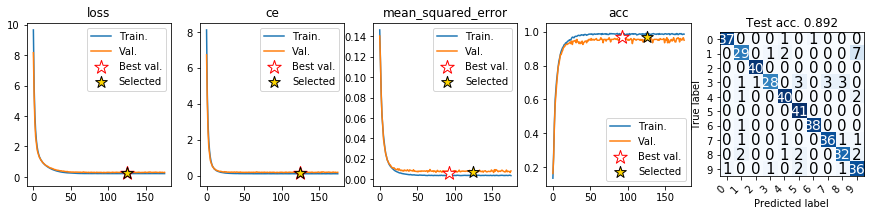

<Figure size 360x288 with 0 Axes>

Epoch 85, val_loss = 7.03e-01, val_acc = 0.92 Restoring model weights from the end of the best epoch
Epoch 86, val_loss = 6.82e-01, val_acc = 0.95 Epoch 00087: early stopping


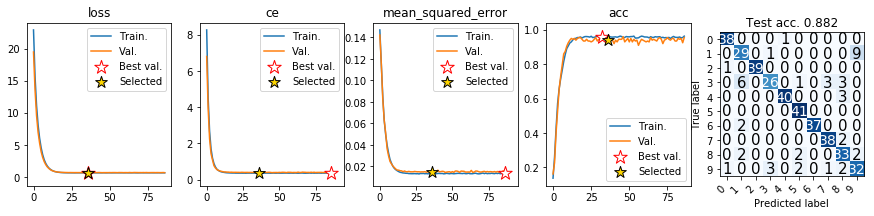

<Figure size 360x288 with 0 Axes>

Epoch 142, val_loss = 1.58e+00, val_acc = 0.90 Restoring model weights from the end of the best epoch
Epoch 143, val_loss = 1.58e+00, val_acc = 0.90 Epoch 00144: early stopping


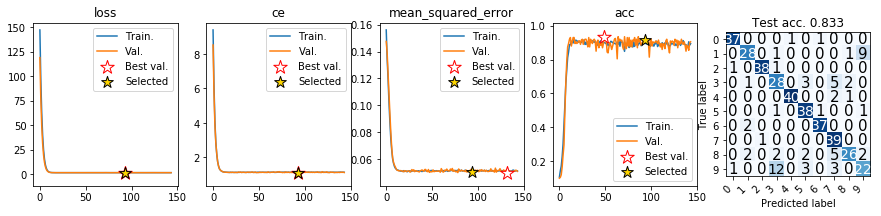

<Figure size 360x288 with 0 Axes>

Best l2 = 0.01


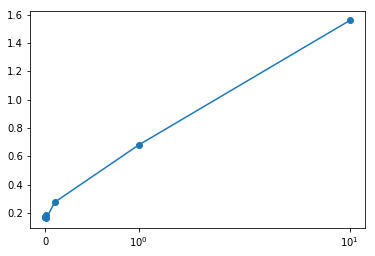

In [6]:
train_method = 'Supervised'

l2_list = numpy.array([0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])

model_supervised_list = []
val_losses = numpy.zeros_like(l2_list)
for i, l2 in enumerate(l2_list):
    model = make_model('categorical_crossentropy', l2=l2)
    history = model.fit(numpy.concatenate([X_weak_train, X_true_train]),
                        numpy.concatenate([Y_weak_train, Y_true_train]),
                        **fit_kwargs)#

    plot_history(history, model, X_test, y_test)
    model_supervised_list.append(model)
    best_epoch = numpy.argmin(model.history.history['val_loss'])
    val_losses[i] = model.history.history['val_loss'][best_epoch]
    plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(l2_list, val_losses, 'o-')
ax.set_xscale("symlog")
best_supervised = numpy.argmin(val_losses)
final_models[train_method] = model_supervised_list[best_supervised]
l2 = l2_list[best_supervised]
print('Best l2 = {}'.format(l2))

# Our method with EM and original M

Train EM with all weak labels

Epoch 145, val_loss = 2.87e-02, val_acc = 0.96 Restoring model weights from the end of the best epoch
Epoch 146, val_loss = 2.87e-02, val_acc = 0.95 Epoch 00147: early stopping


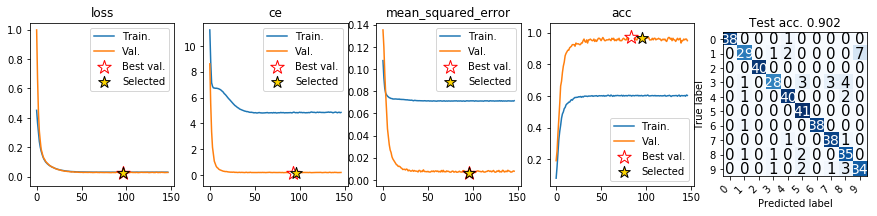

<Figure size 360x288 with 0 Axes>

In [7]:
def EM_log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, K.epsilon(), 1.0-K.epsilon())
    Q = y_true * y_pred
    Z_em_train = Q / K.sum(Q, axis=-1, keepdims=True)
    out = -K.stop_gradient(Z_em_train)*K.log(y_pred)
    return K.mean(out, axis=-1)

model = make_model(EM_log_loss, l2=l2)

M_true = computeM(n_classes, method='supervised')
q_weak = X_weak_train.shape[0] / (X_weak_train.shape[0] + X_true_train.shape[0])
q_true = X_true_train.shape[0] / (X_weak_train.shape[0] + X_true_train.shape[0])
M = numpy.concatenate((q_weak*M_weak, q_true*M_true))

M_true_indices = weak_to_index(Y_true_train, method='supervised') + M_weak.shape[0]
V_true_train = M[M_true_indices]

history = model.fit(numpy.concatenate([X_weak_train, X_true_train]),
                    numpy.concatenate([V_weak_train, V_true_train]),
                    **fit_kwargs)
    
plot_history(history, model, X_test, y_test)

final_models['EM original M'] = model

# Our method with EM and estimated M

../wlc/WLweakener.py:496: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  S[weak_list, :] = alpha


Epoch 142, val_loss = 3.00e-02, val_acc = 0.94 Restoring model weights from the end of the best epoch
Epoch 143, val_loss = 2.87e-02, val_acc = 0.96 Epoch 00144: early stopping


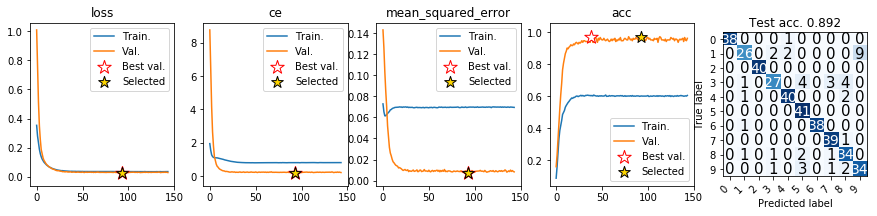

<Figure size 360x288 with 0 Axes>

In [8]:
from wlc.WLweakener import estimate_M

M_estimated = estimate_M(Z_true_train, Y_true_train, range(n_classes), reg='Partial', Z_reg=Z_weak_train)
M_true = computeM(n_classes, method='supervised')

q_estimated = X_weak_train.shape[0] / (X_weak_train.shape[0] + X_true_train.shape[0])
q_true = X_true_train.shape[0] / (X_weak_train.shape[0] + X_true_train.shape[0])
M = numpy.concatenate((q_estimated*M_estimated, q_true*M_true))

M_estimated_indices = weak_to_index(Z_weak_train, method='random_weak')
V_weak_train = M_estimated[M_estimated_indices]

M_true_indices = weak_to_index(Y_true_train, method='supervised') + M_estimated.shape[0]
V_true_train = M[M_true_indices]

model = make_model(EM_log_loss, l2=l2)
history = model.fit(numpy.concatenate([X_weak_train, X_true_train]),
                    numpy.concatenate([V_weak_train, V_true_train]),
                    **fit_kwargs)
    
plot_history(history, model, X_test, y_test)

final_models['EM estimated M'] = model

# Fully weak (lowerbound)

Epoch 165, val_loss = 1.39e+00, val_acc = 0.80 Restoring model weights from the end of the best epoch
Epoch 166, val_loss = 1.38e+00, val_acc = 0.84 Epoch 00167: early stopping


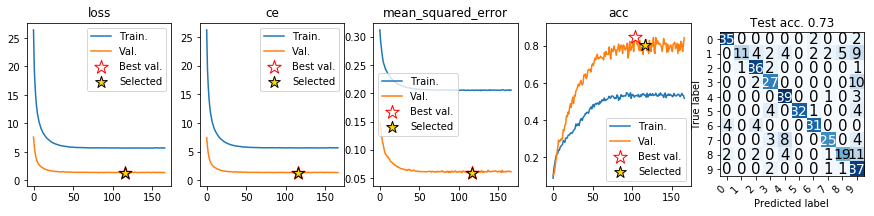

<Figure size 360x288 with 0 Axes>

In [9]:
model = make_model('categorical_crossentropy', l2=l2)

history = model.fit(numpy.concatenate([X_weak_train, X_true_train]),
                    numpy.concatenate([Z_weak_train, Y_true_train]),
                    **fit_kwargs)

plot_history(history, model, X_test, y_test)

final_models['Weak'] = model

Epoch 131, val_loss = 3.18e-02, val_acc = 0.94 Restoring model weights from the end of the best epoch
Epoch 132, val_loss = 3.30e-02, val_acc = 0.94 Epoch 00133: early stopping


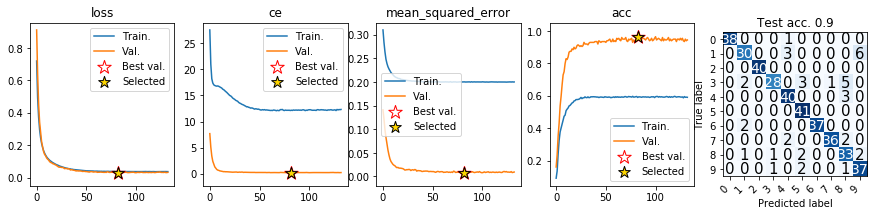

<Figure size 360x288 with 0 Axes>

In [10]:
def OSL_log_loss(y_true, y_pred):
    # Careful, I had to use a global variable here for the number of classes
    # for some reason I can not use y_osl.shape[-1] in the reshape function
    y_pred = K.clip(y_pred, K.epsilon(), 1.0-K.epsilon())
    y_osl = y_true * y_pred
    y_osl_max = K.max(y_osl, axis=-1)
    y_osl_max = K.repeat_elements(y_osl_max, n_classes, 0)
    y_osl_max = K.reshape(y_osl_max, (-1, n_classes))
    y_osl = K.cast(K.equal(y_osl, y_osl_max), y_pred.dtype)
    y_osl = y_osl / K.sum(y_osl, axis=-1, keepdims=True)
    out = -K.stop_gradient(y_osl) * K.log(y_pred)
    return K.mean(out, axis=-1)

model = make_model(OSL_log_loss, l2=l2)

history = model.fit(numpy.concatenate([X_weak_train, X_true_train]),
                    numpy.concatenate([Z_weak_train, Y_true_train]),
                    **fit_kwargs)
    
plot_history(history, model, X_test, y_test)

final_models['OSL'] = model

EM estimated M : 0.8925
EM original M : 0.9025
OSL : 0.9
Supervised : 0.9175
Weak : 0.73


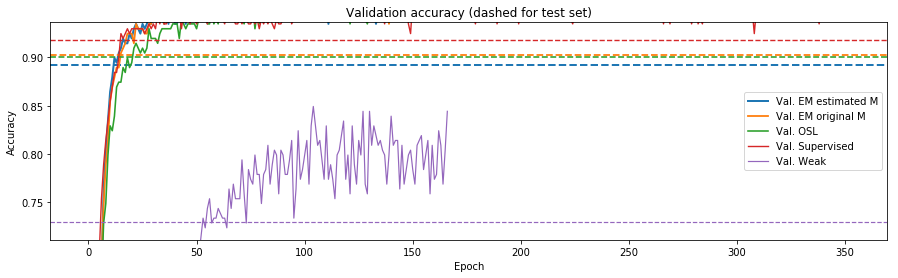

In [11]:
plt.figure(figsize=(15, 4))
lowest_acc = 1.0
highest_acc = 0.0
for i, (key, model) in enumerate(sorted(final_models.items())):
    lw = (len(final_models)+5 - i)/5
    p = plt.plot(model.history.history['val_acc'], lw=lw, label='Val. ' + key)
    test_acc = numpy.mean(model.predict_classes(X_test) == y_test)
    print('{} : {}'.format(key, test_acc))
    plt.axhline(y=test_acc, color=p[0].get_color(), lw=lw, linestyle='--')
    lowest_acc = test_acc if test_acc < lowest_acc else lowest_acc
    highest_acc = test_acc if test_acc > highest_acc else highest_acc
plt.title('Validation accuracy (dashed for test set)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
range_acc = highest_acc - lowest_acc
plt.ylim([lowest_acc-range_acc*0.1, highest_acc+range_acc*0.1])
plt.legend()